In [1]:
from timm.models.efficientnet import tf_efficientnet_b4_ns, tf_efficientnet_b3_ns, \
    tf_efficientnet_b5_ns, tf_efficientnet_b2_ns, tf_efficientnet_b6_ns, tf_efficientnet_b7_ns
import torch
import torch.nn as nn
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.pooling import AdaptiveAvgPool2d
import torch.optim as optim

import cv2
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from model import ImpactClassifier

In [2]:
class TrainClassifierConfig:
    #network = "DeepFakeClassifier"
    #restore_from = '../experiments/effdet5_ds_only_impact_master_23_12_2020/best-checkpoint-011epoch.bin'
    #resume_training = True
    num_workers = 4
    batch_size = 32
    n_epochs = 30
    lr = 1e-3
    folder = '../../experiments/classifiers/effnet7_baseline'

    dataset_name = 'dataset_only_impact_conf_1_vsb_0'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = False
    cosine_annealing = True
    label_smoothing = 0.01
    margin = 2.5

    encoder = {
                #"name" : tf_efficientnet_b7_ns,
                #"features": 2560
                "name" : tf_efficientnet_b7_ns,
                "features": 2560
              }
    
    
    optimizer = {
        "type": "SGD",
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "learning_rate": 0.01,
        "nesterov": True,
        "schedule": {
            "type": "poly",
            "mode": "step",
            "epochs": 40,
            "params": {"max_iter":  100500}
        }
    }

In [3]:
config = TrainClassifierConfig
model = ImpactClassifier(encoder=config.encoder)
device = torch.device('cuda:1')
model = model.to(device)

In [4]:
optimizer = optim.Adam(model.parameters(),
                       lr=config.optimizer["learning_rate"],
                       weight_decay=config.optimizer["weight_decay"])

#scheduler = create_optimizer(conf['optimizer'], model)

In [5]:
bce_best = 100
start_epoch = 0
batch_size = 8#config.optimizer['batch_size']

In [6]:
def get_train_transforms():
    return A.Compose(
        [
            A.Normalize(),
            A.Resize(height=128, width=128, p=1),
            ToTensorV2(p=1.0),
        ]
    )
def get_valid_transforms():
    return A.Compose(
        [   
            A.Normalize(),
            A.Resize(height=128, width=128, p=1),
            ToTensorV2(p=1.0),
        ]
    )

In [7]:
train_video_labels = pd.read_csv(f'../../data/{config.dataset_name}/train_video_labels.csv', index_col=0)
val_video_labels = pd.read_csv(f'../../data/{config.dataset_name}/val_video_labels.csv',  index_col=0)
image_dir = '../../data/train_images_all'

In [8]:
category_id_to_name = {0: 'helmet', 1: 'IMPACT!'}
import cv2
import matplotlib.pyplot as plt

HELMET_COLOR = (0, 255, 0) # Red
IMPACT_COLOR = (255, 0, 0) # Green
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color, thickness=2, margin = 0.):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max  = int(x_min), int(x_max),  int(y_min), int(y_max)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        
        color = IMPACT_COLOR if category_id==1 else HELMET_COLOR
        img = visualize_bbox(img, bbox, class_name, color)
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(img)

In [9]:

from dataset import ImpactDatasetRetriever

In [10]:
import matplotlib.pyplot as plt


In [11]:

#scheduler = create_optimizer(conf['optimizer'], model)
def get_train_transforms():
    return A.Compose(
        [
            A.Normalize(),
            A.Resize(height=128, width=128, p=1),
            ToTensorV2(p=1.0),
        ]
    )
def get_valid_transforms():
    return A.Compose(
        [   
            A.Normalize(),
            A.Resize(height=128, width=128, p=1),
            ToTensorV2(p=1.0),
        ]
    )






In [12]:

from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.utils.data.sampler import SequentialSampler, RandomSampler

In [ ]:
np.round([0.4,0.6,0.8], 0)#

In [13]:

#device = torch.device('cuda:0')
#model.to(device)


reduction = "mean"
loss_fn = BCEWithLogitsLoss(reduction=reduction)


optimizer = optim.Adam(model.parameters(),
                    lr=config.optimizer["learning_rate"],
                    weight_decay=config.optimizer["weight_decay"])



train_video_labels = pd.read_csv(f'../../data/{config.dataset_name}/train_video_labels.csv', index_col=0)
val_video_labels = pd.read_csv(f'../../data/{config.dataset_name}/val_video_labels.csv',  index_col=0)
image_dir = '../../data/train_images_all'


train_dataset = ImpactDatasetRetriever(train_video_labels, image_dir, config, transforms=get_train_transforms(), test=False)
validation_dataset = ImpactDatasetRetriever(val_video_labels, image_dir, config, transforms=get_valid_transforms(), test=True)

In [14]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    sampler=RandomSampler(train_dataset),
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True,
    #collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=config.batch_size * 2,
    sampler=SequentialSampler(validation_dataset),
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=False,
    #collate_fn=collate_fn,
)


In [15]:
output = train_dataset[1492]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


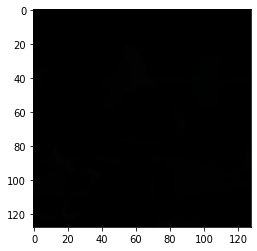

In [16]:
plt.imshow(output['image'].permute(1,2,0).cpu().numpy().astype(int))#.shape

In [17]:
batch = next(iter(train_loader))

In [18]:
imgs.shape

NameError: name 'imgs' is not defined

In [24]:
imgs = batch["image"].to(device)
labels = batch["label"].to(device).float()

In [20]:
!nvidia-smi

Wed Dec 23 20:13:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    On   | 00000000:05:00.0 Off |                  N/A |
|  0%   25C    P2    83W / 370W |   1360MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   

In [22]:
out_labels = model(imgs.to(device))

In [25]:
impact_loss = 0
no_impact_loss = 0
impact_idx = labels > 0.5
no_impact_idx = labels <= 0.5

if torch.sum(impact_idx * 1) > 0:
    impact_loss = loss_fn(out_labels[impact_idx], labels[impact_idx])
if torch.sum(no_impact_idx * 1) > 0:
    no_impact_loss = loss_fn(out_labels[no_impact_idx], labels[no_impact_idx])


loss = (impact_loss + no_impact_loss) / 2

In [31]:
np.round(np.array([0.9]),0).astype(int)

array([1])

In [26]:
impact_loss

tensor(0.7210, device='cuda:1', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [27]:
no_impact_loss

tensor(0.6553, device='cuda:1', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [24]:
output

tensor([[-0.0091],
        [ 0.0917],
        [-0.1853],
        [ 0.2040],
        [-0.1179],
        [-0.0337],
        [ 0.4074],
        [-0.1041],
        [ 0.1090],
        [-0.3803],
        [-0.1158],
        [-0.1436],
        [ 0.0816],
        [ 0.0236],
        [-0.2435],
        [-0.1273],
        [ 0.3129],
        [-0.3273],
        [ 0.1999],
        [ 0.2194],
        [ 0.1285],
        [ 0.2241],
        [-0.1114],
        [ 0.1605],
        [ 0.0174],
        [-0.0521],
        [ 0.2118],
        [ 0.1975],
        [-0.0733],
        [ 0.0604],
        [-0.1224],
        [-0.0969]], device='cuda:1', grad_fn=<AddmmBackward>)

In [22]:
"""
def create_train_transforms(size=300):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ]
    )


def create_val_transforms(size=300):
    return Compose([
        IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
    ])
"""

'\ndef create_train_transforms(size=300):\n    return Compose([\n        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),\n        GaussNoise(p=0.1),\n        GaussianBlur(blur_limit=3, p=0.05),\n        HorizontalFlip(),\n        OneOf([\n            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),\n            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),\n            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),\n        ], p=1),\n        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),\n        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),\n        ToGray(p=0.2),\n        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),\n    ]\n    )\n\n\ndef create_val_transforms(size=300):\n    return